In [2]:
import time
import gym
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

#import tensorlayer as tl
#tl.logging.set_verbosity(tl.logging.DEBUG) # 使tensorflow只对debug信息进行输出
import joblib
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import random 
import math

from pandas import DataFrame
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle
import copy
%matplotlib inline
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
import statistics
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

import klib

import warnings
warnings.filterwarnings("ignore")

# data load 

In [2]:
dirname = "S_icufea_addHighFreq_R7"
mimic_dir = "/home/hanl/local/jupyter_dir/ir_recommend/01.data_preprocessing/02.SAR_data_prepare_v2/03.merge/" + dirname
print(os.listdir(mimic_dir))
df_train = pd.read_csv(mimic_dir + '/train_data.csv')
df_val = pd.read_csv(mimic_dir + '/val_data.csv')
df_test = pd.read_csv(mimic_dir + '/test_data.csv')

df_all = pd.read_csv(mimic_dir + '/all_data.csv')
df_all= df_all.sort_values(["traj_id","starttime"])
df_all["rate"] = df_all["rate"].fillna(method="ffill")
df_all["last_rate"].fillna(df_all["rate"], inplace=True)

df_train= df_train[df_train['rate']>0]
df_val= df_val[df_val['rate']>0]
df_test= df_test[df_test['rate']>0]

df_train= df_train[df_train['rate_bin']<=24]
df_val= df_val[df_val['rate_bin']<=24]
df_test= df_test[df_test['rate_bin']<=24]

df_train.loc[df_train["reward"]<-40, "reward"] = -40
df_val.loc[df_val["reward"]<-40, "reward"] = -40
df_test.loc[df_test["reward"]<-40, "reward"] = -40

df_train= df_train[~df_train['reward'].isna()]
df_val= df_val[~df_val['reward'].isna()]
df_test= df_test[~df_test['reward'].isna()]

df_train.index = pd.RangeIndex(len(df_train.index))
df_val.index = pd.RangeIndex(len(df_val.index))
df_test.index = pd.RangeIndex(len(df_test.index))

['val_data.csv', 'train_data.csv', 'test_data.csv', 'all_data.csv']


In [3]:
dirname = "S_icufea_addHighFreq_R8"
mimic_dir = "/public/hanl/jupyter_dir/ir_recommend/01.data_preprocessing/02.SAR_data_prepare_v2/03.merge/" + dirname
print(os.listdir(mimic_dir))
df_train = pd.read_csv(mimic_dir + '/train_data.csv')
df_val = pd.read_csv(mimic_dir + '/val_data.csv')
df_test = pd.read_csv(mimic_dir + '/test_data.csv')

df_all = pd.read_csv(mimic_dir + '/all_data.csv')
df_all= df_all.sort_values(["traj_id","starttime"])
df_all["rate"] = df_all["rate"].fillna(method="ffill")
df_all["last_rate"].fillna(df_all["rate"], inplace=True)

df_train.index = pd.RangeIndex(len(df_train.index))
df_val.index = pd.RangeIndex(len(df_val.index))
df_test.index = pd.RangeIndex(len(df_test.index))

['all_data.csv', 'train_data.csv', 'val_data.csv', 'test_data.csv']


# 生成两个文件，下个状态在正常范围内(df_met)，下个状态不在正常范围内(df_notmet)，比较两者reward大小的组成

### R_decomposition_60m_add

#### 转变datetime格式为分钟格式，下个状态的血糖状态 

In [3]:
infile = "/home/hanl/local/jupyter_dir/ir_recommend/01.data_preprocessing/02.SAR_data_prepare_v2/02.reward_v7/R_decomposition_60m_add.csv"
df = pd.read_csv(infile)
df["starttime"] = pd.to_datetime(df["starttime"])
df["endtime"] = pd.to_datetime(df["endtime"])
df["traj_id"]= df["traj_id"].astype("float64")
print(df.shape)

# 更改datetime格式为入ICU后的几分钟
datadir = "/home/hanl/local/jupyter_dir/ir_recommend/00.data/raw/"
file = datadir + "icustays_pat_with_r_interval.csv"
df_icu = pd.read_csv(file)
df_icu["intime"] = pd.to_datetime(df_icu["intime"], format='%d/%m/%Y %H:%M:%S')
df_icu=df_icu.loc[:,["stay_id", "intime"]]

tmp_df = pd.merge(df, df_icu, how="left",on="stay_id")
tmp_df["starttime_m"] = (tmp_df["starttime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df["endtime_m"] = (tmp_df["endtime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df = tmp_df.drop(["starttime","endtime","intime"], axis=1)
tmp_df = tmp_df.rename(columns={'starttime_m': 'starttime', "endtime_m":'endtime'})
df = tmp_df
df["starttime"] = round(df["starttime"],2)
df["endtime"] = round(df["endtime"],2)

df_cut = df.loc[:,['stay_id', 'traj_id','fast_control', 'fast_score',
       'steady_control', 'steady_score', 'steady_type', 'fast_type',
       'control_type', 'starttime',"endtime", "reward"]]

df_cut["starttime"] = round(df_cut["starttime"], 2)
df_cut["endtime"] = round(df_cut["endtime"], 2)

df_cut.head(2)

(332958, 13)


,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward
0,30000213,0.0,[],NaN,"[[125.0, 108.0]]",14.222222,TD,NaN,S,2.0,28.0,14.222222
1,30000213,0.0,[],NaN,"[[125.0, 108.0, 97.0]]",11.481481,TD,NaN,S,28.0,88.0,11.481481


In [4]:
df_all_cut = df_all.loc[:,['stay_id', "traj_id", 'rate', 'starttime', 'endtime',"glucose_min", "glucose_max", "glucose_mean","next_glucose_min", "next_glucose_max", "next_glucose_mean" , "reward"]]
df_all_cut["starttime"] = round(df_all_cut["starttime"], 2)
df_all_cut["endtime"] = round(df_all_cut["endtime"], 2)
df_all_cut.head(2)

,stay_id,traj_id,rate,starttime,endtime,glucose_min,glucose_max,glucose_mean,next_glucose_min,next_glucose_max,next_glucose_mean,reward
0,30000213,0,8.0,2.0,28.0,125.0,125.0,125.0,108.0,108.0,108.0,14.222222
1,30000213,0,2.0,28.0,88.0,108.0,108.0,108.0,108.0,108.0,108.0,11.481481


In [5]:
print(df_cut.shape, df_all_cut.shape)
df_merge = pd.merge(df_cut, df_all_cut, how= "inner", on = ["stay_id", "traj_id", "starttime","endtime","reward"])
print(df_merge.shape)
print(df_merge.columns)

(332958, 12) (342300, 12)
(332985, 19)
Index(['stay_id', 'traj_id', 'fast_control', 'fast_score', 'steady_control',
       'steady_score', 'steady_type', 'fast_type', 'control_type', 'starttime',
       'endtime', 'reward', 'rate', 'glucose_min', 'glucose_max',
       'glucose_mean', 'next_glucose_min', 'next_glucose_max',
       'next_glucose_mean'],
      dtype='object')


### df_met， df_notmet

In [6]:
# 生成两个文件，下个状态在正常范围内，下个状态不在正常范围内
tmp_df = df_merge[~df_merge[["reward"]].isnull().T.any()]
tmp_df = tmp_df.loc[:,['stay_id', 'traj_id', 'fast_control', 'fast_score', 'steady_control',
       'steady_score', 'steady_type', 'fast_type', 'control_type', 'starttime',
       'endtime', 'reward', 'rate', 'glucose_min', 'glucose_max',
       'glucose_mean', 'next_glucose_min', 'next_glucose_max',
       'next_glucose_mean']]
print(tmp_df.shape)


df_met = tmp_df[((tmp_df["next_glucose_max"] < 180) & (tmp_df["next_glucose_max"] > 70)) |  (tmp_df["next_glucose_mean"] < 180) & (tmp_df["next_glucose_mean"] > 70) & (tmp_df["next_glucose_min"] < 180) & (tmp_df["next_glucose_min"] > 70)]
df_notmet =  pd.concat([tmp_df, df_met, df_met]).drop_duplicates(keep=False, subset=['stay_id', 'starttime']) 
print(df_met.shape, df_notmet.shape)

(276240, 19)
(227496, 19) (48719, 19)


### df_notmet

<AxesSubplot:xlabel='reward', ylabel='Density'>

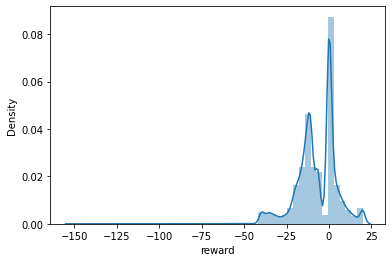

In [8]:
sns.distplot(df_notmet["reward"])

In [9]:
print(df_notmet.shape, df_notmet[df_notmet["reward"]<0].shape, df_notmet[df_notmet["reward"]>=0].shape)
df_M = df_notmet[df_notmet["reward"]>=0]
df_M = df_M[(df_M["control_type"]=="F") | (df_M["control_type"]=="S")]
df_M["d"] = df_M["next_glucose_min"] - df_M["glucose_max"] 
df_M.head(1)

(48719, 19) (27219, 19) (21500, 19)


,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward,rate,glucose_min,glucose_max,glucose_mean,next_glucose_min,next_glucose_max,next_glucose_mean,d
2011,30114063,165.0,[],NaN,"[[91.0, 96.0]]",5.222222,TT,NaN,S,819.65,879.65,5.222222,0.0,68.0,68.0,68.0,68.0,68.0,68.0,0.0


In [17]:
df_M.fast_type.value_counts()    # 降血糖没降下去，降血糖； not_met

HH    8499
HT    1677
Name: fast_type, dtype: int64

In [12]:
df_HH = df_M[df_M["fast_type"].isin(["HH"])]
print(df_HH.shape, df_HH[df_HH["d"]<=0].shape, df_HH[df_HH["d"]>0].shape) 
# d<0 从更高血糖降至较高血糖
df_HH[df_HH["d"]>0]

(8499, 20) (8340, 20) (159, 20)


,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward,rate,glucose_min,glucose_max,glucose_mean,next_glucose_min,next_glucose_max,next_glucose_mean,d
265693,30109052,162.0,"[[500.0, 384.0, 481.0, 420.0]]",2.222222,[],NaN,NaN,HH,F,1486.58,1546.58,2.222222,18.019419,384.00,384.00,384.000000,420.00,481.00,450.500000,36.00
266201,30254621,404.0,"[[194.0, 184.0]]",15.555556,[],NaN,NaN,HH,F,41549.97,41609.97,15.555556,3.997260,168.00,168.00,168.000000,184.00,194.00,189.000000,16.00
266259,30272002,438.0,"[[463.0, 403.0, 429.0, 350.0]]",7.414330,[],NaN,NaN,HH,F,110.13,155.13,7.414330,5.000000,403.00,403.00,403.000000,429.00,429.00,429.000000,26.00
266476,30310155,519.0,"[[311.0, 266.0]]",20.000000,[],NaN,NaN,HH,F,2410.00,2470.00,20.000000,3.000386,85.00,85.00,85.000000,266.00,311.00,288.500000,181.00
266566,30315276,526.0,"[[242.0, 188.0, 182.0]]",13.333333,[],NaN,NaN,HH,F,384.62,444.62,13.333333,0.999820,130.00,130.00,130.000000,182.00,242.00,197.600000,52.00
266591,30323725,552.0,"[[202.0, 187.0]]",2.424242,[],NaN,NaN,HH,F,6087.58,6147.58,2.424242,2.998623,189.00,189.00,189.000000,202.00,202.00,202.000000,13.00
266882,30413300,701.0,"[[357.0, 315.0]]",11.397849,[],NaN,NaN,HH,F,1084.67,1144.67,11.397849,0.999774,98.00,98.00,98.000000,357.00,357.00,357.000000,259.00
267108,30462482,798.0,"[[453.0, 343.0, 350.0]]",8.592593,[],NaN,NaN,HH,F,1695.35,1755.35,8.592593,5.000000,343.00,343.00,343.000000,350.00,350.00,350.000000,7.00
267186,30482528,830.0,"[[192.0, 180.0]]",20.000000,[],NaN,NaN,HH,F,2113.45,2173.45,20.000000,1.496782,118.00,118.00,118.000000,180.00,192.00,186.000000,62.00
267657,30621154,1075.0,"[[301.0, 199.0, 250.0, 234.0]]",0.050125,[],NaN,NaN,HH,F,871.67,930.67,0.050125,8.066798,199.00,199.00,199.000000,250.00,250.00,250.000000,51.00


In [13]:
df_HT = df_M[df_M["fast_type"].isin(["HT"])]
print(df_HT.shape, df_HT[df_HT["d"]<=0].shape, df_HT[df_HT["d"]>0].shape ) 
df_HT[df_HT["d"]<=0]

(1677, 20) (1650, 20) (27, 20)


,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward,rate,glucose_min,glucose_max,glucose_mean,next_glucose_min,next_glucose_max,next_glucose_mean,d
306475,30007565,16.0,"[[262.0, 191.0, 157.0]]",3.627451,[[157.0]],NaN,NaN,HT,F,6688.00,6748.00,3.627451,16.004974,191.0,191.0,191.0,191.0,191.0,191.0,0.0
306481,30012944,34.0,"[[261.0, 244.0, 190.0, 157.0]]",4.888889,[[157.0]],NaN,NaN,HT,F,174.00,234.00,4.888889,7.500732,190.0,244.0,233.2,190.0,190.0,190.0,-54.0
306501,30041848,73.0,"[[244.0, 183.0, 110.0]]",8.222222,[[110.0]],NaN,NaN,HT,F,2564.60,2624.60,8.222222,20.014683,183.0,183.0,183.0,183.0,183.0,183.0,0.0
306523,30065590,116.0,"[[186.0, 124.0]]",7.111111,[[124.0]],NaN,NaN,HT,F,166.00,226.00,7.111111,7.001167,186.0,186.0,186.0,186.0,186.0,186.0,0.0
306529,30082614,134.0,"[[212.0, 132.0]]",5.318352,[[132.0]],NaN,NaN,HT,F,920.37,980.37,5.318352,6.994552,212.0,212.0,212.0,212.0,212.0,212.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317910,39959122,16570.0,"[[190.0, 150.0]]",2.222222,[[150.0]],NaN,NaN,HT,F,4022.03,4082.03,2.222222,5.047955,190.0,190.0,190.0,190.0,190.0,190.0,0.0
317914,39959122,16570.0,"[[238.0, 158.0]]",11.111111,[[158.0]],NaN,NaN,HT,F,5681.03,5740.03,11.111111,10.008733,238.0,238.0,238.0,158.0,238.0,198.0,-80.0
317917,39968693,16581.0,"[[209.0, 167.0]]",5.507246,[[167.0]],NaN,NaN,HT,F,590.20,650.20,5.507246,6.986512,196.0,218.0,208.0,167.0,209.0,202.0,-51.0
317921,39972385,16587.0,"[[228.0, 198.0, 149.0]]",2.413793,[[149.0]],NaN,NaN,HT,F,968.13,1028.13,2.413793,6.995862,228.0,228.0,228.0,198.0,198.0,198.0,-30.0


In [18]:
df_M.steady_type.value_counts()

TT    29
TD    21
TH    17
Name: steady_type, dtype: int64

In [15]:
df_M[df_M["steady_type"].isin(["TD","TT"])]#.shape # steady_control少一些数据

,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward,rate,glucose_min,glucose_max,glucose_mean,next_glucose_min,next_glucose_max,next_glucose_mean,d
2011,30114063,165.0,[],NaN,"[[91.0, 96.0]]",5.222222,TT,NaN,S,819.65,879.65,5.222222,0.000000,68.0,68.0,68.000000,68.0,68.0,68.000000,0.0
5328,30277942,445.0,[],NaN,"[[116.0, 120.0]]",20.000000,TD,NaN,S,2524.77,2584.77,20.000000,4.000000,215.0,215.0,215.000000,215.0,215.0,215.000000,0.0
24627,31190487,1963.0,[],NaN,"[[177.0, 175.0]]",1.702128,TT,NaN,S,649.82,709.82,1.702128,5.000041,177.0,177.0,177.000000,184.0,184.0,184.000000,7.0
28265,31346369,2250.0,[],NaN,"[[170.0, 132.0]]",12.127660,TD,NaN,S,1041.77,1056.77,12.127660,20.163378,170.0,201.0,185.500000,170.0,201.0,185.500000,-31.0
30804,31462161,2454.0,[],NaN,"[[156.0, 110.0]]",9.550827,TD,NaN,S,646.53,706.53,9.550827,5.001869,181.0,181.0,181.000000,181.0,181.0,181.000000,0.0
31367,31504326,2515.0,[],NaN,"[[134.0, 130.0]]",19.787234,TD,NaN,S,13591.00,13651.00,19.787234,12.990689,190.0,190.0,190.000000,190.0,190.0,190.000000,0.0
34098,31624203,2736.0,[],NaN,"[[83.0, 82.0]]",2.777778,TT,NaN,S,718.43,778.43,2.777778,9.992043,197.0,197.0,197.000000,197.0,197.0,197.000000,0.0
36306,31728367,2915.0,[],NaN,"[[167.0, 177.0]]",3.404255,TT,NaN,S,850.25,910.25,3.404255,14.045351,167.0,217.0,192.000000,167.0,217.0,192.000000,-50.0
42813,32021927,3400.0,[],NaN,"[[148.0, 154.0]]",12.340426,TT,NaN,S,798.10,858.10,12.340426,0.000000,184.0,184.0,184.000000,184.0,184.0,184.000000,0.0
47015,32188791,3687.0,[],NaN,"[[178.0, 158.0]]",5.106383,TT,NaN,S,465.60,525.60,5.106383,14.990211,259.0,259.0,259.000000,259.0,259.0,259.000000,0.0


In [201]:
df_M[df_M["steady_type"].isin(["TH"])] # 上升到hype （=180）

,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward,rate,glucose_min,glucose_max,glucose_mean,next_glucose_min,next_glucose_max,next_glucose_mean,d
258852,31718210,2892.0,[[180.0]],NaN,"[[125.0, 180.0]]",0.0,TH,NaN,S,17873.13,17933.13,0.0,3.996069,125.0,125.0,125.00,180.0,180.0,180.0,55.0
258940,31792549,3018.0,[[180.0]],NaN,"[[132.0, 180.0]]",0.0,TH,NaN,S,17729.80,17789.80,0.0,8.045893,132.0,132.0,132.00,180.0,180.0,180.0,48.0
259048,31935277,3249.0,[[180.0]],NaN,"[[117.0, 180.0]]",0.0,TH,NaN,S,531.00,591.00,0.0,10.000000,117.0,117.0,117.00,180.0,180.0,180.0,63.0
259334,32208757,3720.0,[[180.0]],NaN,"[[123.0, 180.0]]",0.0,TH,NaN,S,8855.00,8909.00,0.0,1.999333,123.0,123.0,123.00,180.0,180.0,180.0,57.0
259383,32263948,3817.0,[[180.0]],NaN,"[[128.0, 180.0]]",0.0,TH,NaN,S,15578.58,15638.58,0.0,2.998847,128.0,128.0,128.00,180.0,180.0,180.0,52.0
259505,32462311,4100.0,[[180.0]],NaN,"[[129.0, 180.0]]",0.0,TH,NaN,S,2133.43,2193.43,0.0,2.501720,129.0,129.0,129.00,180.0,180.0,180.0,51.0
260078,33166854,5292.0,[[180.0]],NaN,"[[124.0, 180.0]]",0.0,TH,NaN,S,907.00,967.00,0.0,0.000000,124.0,124.0,124.00,180.0,180.0,180.0,56.0
260795,34060638,6745.0,[[180.0]],NaN,"[[126.0, 133.0, 133.0, 180.0]]",0.0,TH,NaN,S,994.68,1054.68,0.0,0.500200,126.0,133.0,131.25,180.0,180.0,180.0,47.0
260854,34156814,6937.0,[[180.0]],NaN,"[[118.0, 180.0]]",0.0,TH,NaN,S,10033.07,10093.07,0.0,2.008711,118.0,118.0,118.00,180.0,180.0,180.0,62.0
261917,35601389,9259.0,[[180.0]],NaN,"[[127.0, 180.0]]",0.0,TH,NaN,S,1170.37,1230.37,0.0,9.006289,127.0,127.0,127.00,180.0,180.0,180.0,53.0


### df_met

In [24]:
df_met[df_met["reward"]>=-40]

,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward,rate,glucose_min,glucose_max,glucose_mean,next_glucose_min,next_glucose_max,next_glucose_mean
0,30000213,0.0,[],NaN,"[[125.0, 108.0]]",14.222222,TD,NaN,S,2.00,28.00,14.222222,8.000000,125.0,125.0,125.0,108.0,108.0,108.0
1,30000213,0.0,[],NaN,"[[125.0, 108.0, 97.0]]",11.481481,TD,NaN,S,28.00,88.00,11.481481,2.000000,108.0,108.0,108.0,108.0,108.0,108.0
2,30000213,0.0,[],NaN,"[[125.0, 108.0, 97.0, 156.0]]",11.164303,TD,NaN,S,40.00,100.00,11.164303,2.000000,108.0,108.0,108.0,97.0,156.0,126.5
3,30000213,0.0,[],NaN,"[[108.0, 97.0, 156.0]]",8.219070,TD,NaN,S,100.00,160.00,8.219070,0.000000,97.0,156.0,126.5,97.0,156.0,126.5
4,30001148,1.0,[],NaN,"[[109.0, 86.0]]",6.111111,TT,NaN,S,544.02,604.02,6.111111,2.000000,109.0,109.0,109.0,86.0,106.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332976,39961214,16575.0,"[[190.0, 179.0]]",0.000000,"[[166.0, 190.0], [179.0]]",-15.709220,TH,NaN,B,555.67,615.67,-15.709220,4.001536,166.0,190.0,170.8,179.0,179.0,179.0
332977,39972385,16587.0,"[[228.0, 198.0, 149.0], [193.0]]",2.413793,"[[149.0, 193.0]]",-8.975177,TH,HH,B,973.13,1033.13,-8.975177,6.995862,198.0,198.0,198.0,149.0,193.0,157.8
332978,39972385,16587.0,"[[198.0, 149.0], [193.0, 165.0]]",2.500000,"[[149.0, 193.0], [165.0]]",-8.975177,TH,HT,B,1033.13,1093.13,-8.975177,4.997045,149.0,193.0,157.8,165.0,193.0,179.0
332979,39972385,16587.0,"[[193.0, 165.0]]",0.000000,"[[149.0, 193.0], [165.0, 160.0]]",-12.804965,TH,NaN,B,1092.13,1152.13,-12.804965,4.997045,165.0,193.0,179.0,160.0,165.0,162.5


<AxesSubplot:xlabel='reward', ylabel='Density'>

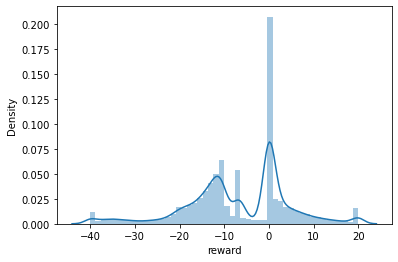

In [26]:
sns.distplot(df_notmet[df_notmet["reward"]>=-40]["reward"])

In [19]:
print(df_met.shape,df_met[df_met["reward"]>0].shape, df_met[df_met["reward"]<=0].shape)
df_L = df_met[df_met["reward"]<=0]
df_L = df_L[(df_L["control_type"]=="F") | (df_L["control_type"]=="S")]

(227496, 19) (213334, 19) (14162, 19)


In [20]:
df_L.steady_type.value_counts()

TL    4968
TH    2363
Name: steady_type, dtype: int64

In [213]:
df_L[df_L["steady_type"].isin(["TH"])]

,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward,rate,glucose_min,glucose_max,glucose_mean,next_glucose_min,next_glucose_max,next_glucose_mean
257292,30006067,12.0,[[205.0]],NaN,"[[89.0, 128.0, 205.0]]",-12.055556,TH,NaN,S,379.00,439.00,-12.055556,4.993905,128.0,128.0,128.0,128.0,128.0,128.0
257297,30007565,15.0,[[220.0]],NaN,"[[154.0, 220.0]]",-15.602837,TH,NaN,S,3341.00,3401.00,-15.602837,1.000000,154.0,154.0,154.0,154.0,154.0,154.0
257299,30007565,15.0,[[180.0]],NaN,"[[118.0, 138.0, 158.0, 180.0]]",-4.255319,TH,NaN,S,5366.00,5426.00,-4.255319,3.006297,138.0,158.0,148.0,158.0,180.0,169.0
257307,30009339,30.0,[[192.0]],NaN,"[[131.0, 120.0, 192.0]]",-2.000000,TH,NaN,S,21284.00,21344.00,-2.000000,3.000000,120.0,120.0,120.0,120.0,192.0,156.0
257310,30015142,37.0,[[185.0]],NaN,"[[142.0, 120.0, 185.0]]",-2.748227,TH,NaN,S,655.08,715.08,-2.748227,7.002541,142.0,142.0,142.0,120.0,120.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265495,39972385,16588.0,[[232.0]],NaN,"[[178.0, 232.0]]",-27.815603,TH,NaN,S,2122.13,2182.13,-27.815603,2.000704,178.0,178.0,178.0,178.0,178.0,178.0
265497,39972385,16589.0,[[211.0]],NaN,"[[111.0, 104.0, 129.0, 211.0]]",-12.944444,TH,NaN,S,5412.13,5472.13,-12.944444,2.999323,104.0,129.0,110.4,129.0,211.0,170.0
265498,39975904,16591.0,[[207.0]],NaN,"[[178.0, 207.0]]",-23.648936,TH,NaN,S,331.77,391.77,-23.648936,3.000000,178.0,178.0,178.0,178.0,178.0,178.0
265504,39990190,16611.0,[[184.0]],NaN,"[[155.0, 152.0, 184.0]]",-9.390071,TH,NaN,S,732.63,792.63,-9.390071,11.993971,155.0,155.0,155.0,152.0,184.0,168.0


In [21]:
df_L.fast_type.value_counts()

HT     407
HMH     28
HH       9
Name: fast_type, dtype: int64

# reward来源分析
- reward范围在-40到20， 按size=5划分reward为12个区间
- 比较control_type, control_type,fast_type组成

In [31]:
infile = "/public/hanl/jupyter_dir/ir_recommend/01.data_preprocessing/02.SAR_data_prepare_v2/02.reward_v8/R_decomposition_60m_add.csv"
df = pd.read_csv(infile)
df["starttime"] = pd.to_datetime(df["starttime"])
df["endtime"] = pd.to_datetime(df["endtime"])
df["traj_id"]= df["traj_id"].astype("float64")
print(df.head(1))

# 更改datetime格式为入ICU后的几分钟
datadir = "/public/hanl/jupyter_dir/ir_recommend/00.data/raw/"
file = datadir + "icustays_pat_with_r_interval.csv"
df_icu = pd.read_csv(file)
df_icu["intime"] = pd.to_datetime(df_icu["intime"], format='%d/%m/%Y %H:%M:%S')
df_icu=df_icu.loc[:,["stay_id", "intime"]]

tmp_df = pd.merge(df, df_icu, how="left",on="stay_id")
tmp_df["starttime_m"] = (tmp_df["starttime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df["endtime_m"] = (tmp_df["endtime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df = tmp_df.drop(["starttime","endtime","intime"], axis=1)
tmp_df = tmp_df.rename(columns={'starttime_m': 'starttime', "endtime_m":'endtime'})
df = tmp_df
df["starttime"] = round(df["starttime"],2)
df["endtime"] = round(df["endtime"],2)

df_cut = df.loc[:,['stay_id', 'traj_id','fast_control', 'fast_score',
       'steady_control', 'steady_score', 'steady_type', 'fast_type',
       'control_type', 'starttime', "endtime","reward","rate"]]

tmp_df = df_cut
tmp_df.head(1)

    stay_id  traj_id           starttime             endtime  rate  \
0  30000213      0.0 2162-06-21 05:40:00 2162-06-21 06:06:00   8.0   

  fast_control  fast_score    steady_control  steady_score  reward  \
0           []         NaN  [[125.0, 108.0]]        14.625  14.625   

  steady_type fast_type control_type  
0          TD       NaN            S  


,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward,rate
0,30000213,0.0,[],NaN,"[[125.0, 108.0]]",14.625,TD,NaN,S,2.0,28.0,14.625,8.0


In [32]:
df = tmp_df
cut_point = [-40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 21]

max_v = max(df["reward"])
v_bin = {}

tmp_v = cut_point[0]
cut_point = cut_point[1:]
idx = 0
while tmp_v <= max_v:
    last_tmp_v = tmp_v
    tmp_v = cut_point[idx]
    v_bin[(last_tmp_v, tmp_v)] = idx
    idx += 1
print(v_bin)

v_bin2 ={}
lst = df["reward"].unique().tolist()
for i in lst:
    for keys in v_bin.keys():
        if (i >= keys[0]) & (i<keys[1]):
            v_bin2[i] = v_bin[keys]

df["reward_bin"] = df.reward.map(v_bin2)
df = df.sort_values(by=["traj_id", "stay_id", "starttime"])
df.index = pd.RangeIndex(len(df.index))

v_bin_reverse = {}
for i,j in v_bin.items():
    v_bin_reverse[j] = i

{(-40, -35): 0, (-35, -30): 1, (-30, -25): 2, (-25, -20): 3, (-20, -15): 4, (-15, -10): 5, (-10, -5): 6, (-5, 0): 7, (0, 5): 8, (5, 10): 9, (10, 15): 10, (15, 21): 11}


In [41]:
#df = df_rate_9_15

shape_lst = []
HT_lst = []
HL_lst = []
HMH_lst = []
HH_lst = []
TD_lst = []
TT_lst = []
TH_lst = []
TL_lst = []
x_reward = []

type_lst = ['HH', 'HT', "HL", "HMH"]
type2_lst = ['TD', 'TT', 'TH', 'TL']

for i in range(0,12,1):
    x_reward.append(v_bin_reverse[i])
    df_filt = df[df["reward_bin"]==i]
    
    fast_lst = df_filt.fast_type.value_counts().keys().tolist()
    df_tmp = df_filt.fast_type.value_counts()
    
    steady_lst = df_filt.steady_type.value_counts().keys().tolist()
    df_tmp2 = df_filt.steady_type.value_counts()
    
    for type1 in list(set(type_lst).difference(set(fast_lst))):
        df_tmp[type1] =0
    for type2 in list(set(type2_lst).difference(set(steady_lst))):
        df_tmp2[type2] =0
        
    shape_lst.append(df_filt.shape[0])
    HT_lst.append(df_tmp["HT"])
    HL_lst.append(df_tmp["HL"])
    HMH_lst.append(df_tmp["HMH"])
    HH_lst.append(df_tmp["HH"])

    TD_lst.append(df_tmp2["TD"])
    TT_lst.append(df_tmp2["TT"])
    TH_lst.append(df_tmp2["TH"])
    TL_lst.append(df_tmp2["TL"])
  

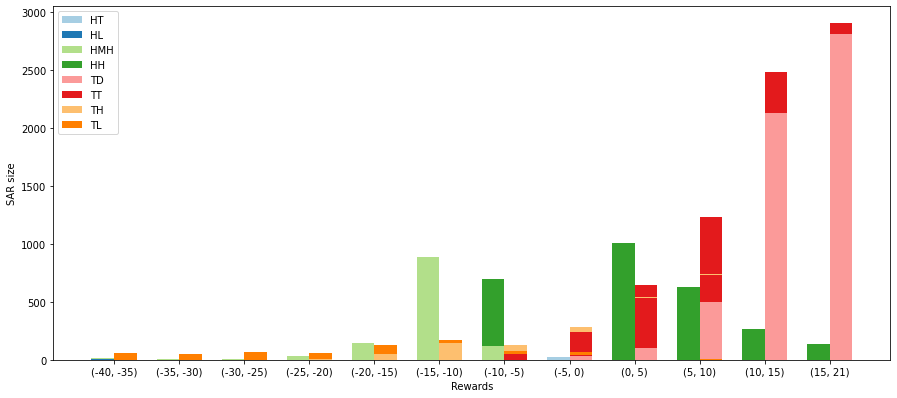

In [43]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['(-40, -35)', "(-35, -30)", "(-30, -25)", "(-25, -20)", "(-20, -15)", "(-15, -10)", "(-10, -5)", "(-5, 0)", "(0, 5)", "(5, 10)", "(10, 15)", "(15, 21)"]
x = np.arange(len(labels))

width = 0.35 
fig, ax = plt.subplots(figsize=(15, 6.5))  
ax.bar(x - width/2, HT_lst, width, color='#a6cee3', label='HT')  
ax.bar(x - width/2, HL_lst, width, color='#1f78b4',bottom=HT_lst, label='HL')
ax.bar(x - width/2, HMH_lst, width, color='#b2df8a',bottom=HL_lst, label='HMH')
ax.bar(x - width/2, HH_lst, width, color='#33a02c',bottom=HMH_lst, label='HH')

ax.bar(x + width/2, TD_lst, width, color='#fb9a99', label='TD')  
ax.bar(x + width/2, TT_lst, width, color='#e31a1c',bottom=TD_lst, label='TT')
ax.bar(x + width/2, TH_lst, width, color='#fdbf6f',bottom=TT_lst, label='TH')
ax.bar(x + width/2, TL_lst, width, color='#ff7f00',bottom=TH_lst, label='TL')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.xlabel('Rewards') 
plt.ylabel('SAR size')  
plt.legend()
plt.show()

In [57]:
infile = "/public/hanl/jupyter_dir/ir_recommend/01.data_preprocessing/02.SAR_data_prepare_v2/02.reward_v8/R_decomposition_60m_add.csv"
df = pd.read_csv(infile)
df["starttime"] = pd.to_datetime(df["starttime"])
df["endtime"] = pd.to_datetime(df["endtime"])
df["traj_id"]= df["traj_id"].astype("float64")
print(df.head(1))

# 更改datetime格式为入ICU后的几分钟
datadir = "/public/hanl/jupyter_dir/ir_recommend/00.data/raw/"
file = datadir + "icustays_pat_with_r_interval.csv"
df_icu = pd.read_csv(file)
df_icu["intime"] = pd.to_datetime(df_icu["intime"],format='%d/%m/%Y %H:%M:%S')
df_icu=df_icu.loc[:,["stay_id", "intime"]]

tmp_df = pd.merge(df, df_icu, how="left",on="stay_id")
tmp_df["starttime_m"] = (tmp_df["starttime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df["endtime_m"] = (tmp_df["endtime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df = tmp_df.drop(["starttime","endtime","intime"], axis=1)
tmp_df = tmp_df.rename(columns={'starttime_m': 'starttime', "endtime_m":'endtime'})
df = tmp_df
df["starttime"] = round(df["starttime"],2)
df["endtime"] = round(df["endtime"],2)

df_cut = df.loc[:,['stay_id', 'traj_id','fast_control', 'fast_score',
       'steady_control', 'steady_score', 'steady_type', 'fast_type',
       'control_type', 'starttime', "endtime","reward","rate"]]

tmp_df = df_cut
tmp_df.head(1)

    stay_id  traj_id           starttime             endtime  rate  \
0  30000213      0.0 2162-06-21 05:40:00 2162-06-21 06:06:00   8.0   

  fast_control  fast_score    steady_control  steady_score  reward  \
0           []         NaN  [[125.0, 108.0]]        14.625  14.625   

  steady_type fast_type control_type  
0          TD       NaN            S  


,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward,rate
0,30000213,0.0,[],NaN,"[[125.0, 108.0]]",14.625,TD,NaN,S,2.0,28.0,14.625,8.0


In [58]:
df = tmp_df
cut_point = [-40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 21]

max_v = max(df["reward"])
v_bin = {}

tmp_v = cut_point[0]
cut_point = cut_point[1:]
idx = 0
while tmp_v <= max_v:
    last_tmp_v = tmp_v
    tmp_v = cut_point[idx]
    v_bin[(last_tmp_v, tmp_v)] = idx
    idx += 1
print(v_bin)

v_bin2 ={}
lst = df["reward"].unique().tolist()
for i in lst:
    for keys in v_bin.keys():
        if (i >= keys[0]) & (i<keys[1]):
            v_bin2[i] = v_bin[keys]

df["reward_bin"] = df.reward.map(v_bin2)
df = df.sort_values(by=["traj_id", "stay_id", "starttime"])
df.index = pd.RangeIndex(len(df.index))

v_bin_reverse = {}
for i,j in v_bin.items():
    v_bin_reverse[j] = i

{(-40, -35): 0, (-35, -30): 1, (-30, -25): 2, (-25, -20): 3, (-20, -15): 4, (-15, -10): 5, (-10, -5): 6, (-5, 0): 7, (0, 5): 8, (5, 10): 9, (10, 15): 10, (15, 21): 11}


In [59]:
df_rate_9_15 = df[(df["rate"]>=9) & (df["rate"]<=15)]

In [85]:
dirname = "S_icufea_addHighFreq_R8"
mimic_dir = "/public/hanl/jupyter_dir/ir_recommend/01.data_preprocessing/02.SAR_data_prepare_v2/03.merge/" + dirname
print(os.listdir(mimic_dir))
df_train = pd.read_csv(mimic_dir + '/train_data.csv')
df_val = pd.read_csv(mimic_dir + '/val_data.csv')
df_test = pd.read_csv(mimic_dir + '/test_data.csv')

df_all = pd.read_csv(mimic_dir + '/all_data.csv')
df_all= df_all.sort_values(["traj_id","starttime"])
df_all["rate"] = df_all["rate"].fillna(method="ffill")
df_all["last_rate"].fillna(df_all["rate"], inplace=True)



['all_data.csv', 'train_data.csv', 'val_data.csv', 'test_data.csv']


In [100]:
df_all_cut = df_all.loc[:,["stay_id","traj_id", "starttime","endtime", "rate", "last_rate", "glucose_mean", "glucose_max", "glucose_min", 'type1_diabetes', 'type2_diabetes', 'd_glucose_mean','colloid_bolus_win', 'dex_win', 'OS_bt1_0', 'OS_bt1_1', 'OS_bt1_2', 'OS_t0_0', 'OS_t0_1', 'OS_t0_2', 'OS_t1_0', 'OS_t1_1', 'OS_t1_2', 'OS_t2_0', 'OS_t2_1', 'OS_t2_2', 'OS_t3_0', 'OS_t3_1', 'OS_t3_2', 'OS_t4_0', 'OS_t4_1', 'OS_t4_2', 'OS_t5_0', 'OS_t5_1', 'OS_t5_2', 'OS_t6_0', 'OS_t6_1', 'OS_t6_2', 'OS_t7_0', 'OS_t7_1', 'OS_t7_2', 'OS_t8_0', 'OS_t8_1', 'OS_t8_2', 'OS_bv1_0', 'OS_bv1_1', 'OS_bv1_2', 'OS_v0_0', 'OS_v0_1', 'OS_v0_2', 'OS_v1_0', 'OS_v1_1', 'OS_v1_2', 'OS_v2_0', 'OS_v2_1', 'OS_v2_2', 'OS_v3_0', 'OS_v3_1', 'OS_v3_2', 'OS_v4_0', 'OS_v4_1', 'OS_v4_2', 'OS_v5_0', 'OS_v5_1', 'OS_v5_2', 'OS_v6_0', 'OS_v6_1', 'OS_v6_2', 'OS_v7_0', 'OS_v7_1', 'OS_v7_2', 'OS_v8_0', 'OS_v8_1', 'OS_v8_2', 'L_bt1_0', 'L_bt1_1', 'L_t0_0', 'L_t0_1', 'L_t1_0', 'L_t1_1', 'L_t2_0', 'L_t2_1', 'L_t3_0', 'L_t3_1', 'L_t4_0', 'L_t4_1', 'L_t5_0', 'L_t5_1', 'L_t6_0', 'L_t6_1', 'L_t7_0', 'L_t7_1', 'L_t8_0', 'L_t8_1', 'L_t9_0', 'L_t9_1', 'L_t10_0', 'L_t10_1', 'L_t11_0', 'L_t11_1', 'L_t12_0', 'L_t12_1', 'L_t13_0', 'L_t13_1', 'L_t14_0', 'L_t14_1', 'L_t15_0', 'L_t15_1', 'L_t16_0', 'L_t16_1', 'L_t17_0', 'L_t17_1', 'L_t18_0', 'L_t18_1', 'L_t19_0', 'L_t19_1', 'L_t20_0', 'L_t20_1', 'L_t21_0', 'L_t21_1', 'L_t22_0', 'L_t22_1', 'L_t23_0', 'L_t23_1', 'L_t24_0', 'L_t24_1', 'L_bv1_0', 'L_bv1_1', 'L_v0_0', 'L_v0_1', 'L_v1_0', 'L_v1_1', 'L_v2_0', 'L_v2_1', 'L_v3_0', 'L_v3_1', 'L_v4_0', 'L_v4_1', 'L_v5_0', 'L_v5_1', 'L_v6_0', 'L_v6_1', 'L_v7_0', 'L_v7_1', 'L_v8_0', 'L_v8_1', 'L_v9_0', 'L_v9_1', 'L_v10_0', 'L_v10_1', 'L_v11_0', 'L_v11_1', 'L_v12_0', 'L_v12_1', 'L_v13_0', 'L_v13_1', 'L_v14_0', 'L_v14_1', 'L_v15_0', 'L_v15_1', 'L_v16_0', 'L_v16_1', 'L_v17_0', 'L_v17_1', 'L_v18_0', 'L_v18_1', 'L_v19_0', 'L_v19_1', 'L_v20_0', 'L_v20_1', 'L_v21_0', 'L_v21_1', 'L_v22_0', 'L_v22_1', 'L_v23_0', 'L_v23_1', 'L_v24_0', 'L_v24_1', 'M_bt1', 'M_t0', 'M_t1', 'M_t2', 'M_t3', 'M_t4', 'M_t5', 'M_t6', 'M_t7', 'M_t8', 'M_t9', 'M_t10', 'M_t11', 'M_t12', 'M_bv1', 'M_v0', 'M_v1', 'M_v2', 'M_v3', 'M_v4', 'M_v5', 'M_v6', 'M_v7', 'M_v8', 'M_v9', 'M_v10', 'M_v11', 'M_v12']]

In [64]:
df_merge = pd.merge(df_rate_9_15, df_all_cut, how="inner", on=["stay_id","starttime","endtime","rate"])

<AxesSubplot:>

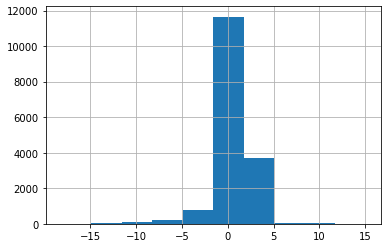

In [68]:
df_merge["d_rate"] = df_merge["rate"] - df_merge["last_rate"]
df_merge["d_rate"].hist()

In [221]:
df_all_cut["idx"] = range(len(df_all_cut))

In [222]:
idx_lst = pd.merge(df_all_cut, df_rate_9_15, how="inner", on=["stay_id","starttime","endtime","rate"])["idx"]
idx_lst = [i-1 for i in idx_lst]

Text(0.5, 0, 'rate')

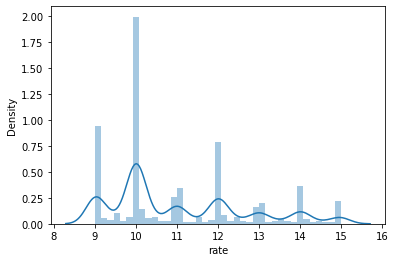

In [225]:
sns.distplot(df_rate_9_15["rate"])
plt.xlabel("rate")

Text(0.5, 0, 'last_rate')

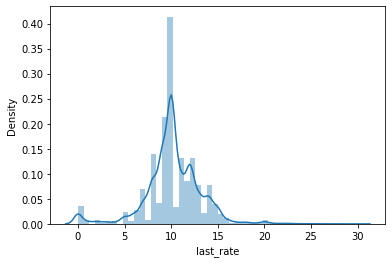

In [223]:
sns.distplot(df_all_cut[df_all_cut["idx"].isin(idx_lst)]["rate"])
plt.xlabel("last_rate")

((11617, 206), (8411, 206))

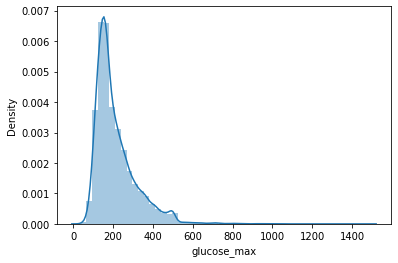

In [96]:
tmp_df = df_all_cut[df_all_cut["idx"].isin(idx_lst)]
sns.distplot(tmp_df["glucose_max"])
tmp_df[tmp_df["glucose_max"]>=150].shape, tmp_df[tmp_df["glucose_max"]<180].shape

###### traj_lst = set(df_rate_9_15["traj_id"].tolist())
traj_lst

In [302]:
df_ac1 = pd.read_csv("/public/hanl/jupyter_dir/ir_recommend/01.data_preprocessing/02.SAR_data_prepare_v2/00.action/A_IR_win60.csv")
df_ac1["starttime"] = pd.to_datetime(df_ac1["starttime"])
df_ac1["endtime"] = pd.to_datetime(df_ac1["endtime"])

# 更改datetime格式为入ICU后的几分钟
datadir = "/home/hanl/local/jupyter_dir/ir_recommend/00.data/raw/"
file = datadir + "icustays_pat_with_r_interval.csv"
df_icu = pd.read_csv(file)
df_icu["intime"] = pd.to_datetime(df_icu["intime"], format='%d/%m/%Y %H:%M:%S')
df_icu=df_icu.loc[:,["stay_id", "intime"]]

tmp_df = pd.merge(df_ac1, df_icu, how="left",on="stay_id")
tmp_df["starttime_m"] = (tmp_df["starttime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df["endtime_m"] = (tmp_df["endtime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df = tmp_df.drop(["starttime","endtime","intime"], axis=1)
tmp_df = tmp_df.rename(columns={'starttime_m': 'starttime', "endtime_m":'endtime'})
df_ac1 = tmp_df
df_ac1["starttime"] = round(df_ac1["starttime"],2)
df_ac1["endtime"] = round(df_ac1["endtime"],2)
df_ac1.head(2)

,stay_id,amount,rate,traj_id,starttime,endtime
0,30000213,3.466667,8.0,0,2.0,28.0
1,30000213,2.000000,2.0,0,28.0,88.0


In [204]:
df_ac = pd.read_csv("/public/hanl/jupyter_dir/ir_recommend/01.data_preprocessing/02.SAR_data_prepare_v2/00.action//A_insulin_regular.csv")
df_ac["starttime"] = pd.to_datetime(df_ac["starttime"])
df_ac["endtime"] = pd.to_datetime(df_ac["endtime"])

# 更改datetime格式为入ICU后的几分钟
datadir = "/home/hanl/local/jupyter_dir/ir_recommend/00.data/raw/"
file = datadir + "icustays_pat_with_r_interval.csv"
df_icu = pd.read_csv(file)
df_icu["intime"] = pd.to_datetime(df_icu["intime"], format='%d/%m/%Y %H:%M:%S')
df_icu=df_icu.loc[:,["stay_id", "intime"]]

tmp_df = pd.merge(df_ac, df_icu, how="left",on="stay_id")
tmp_df["starttime_m"] = (tmp_df["starttime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df["endtime_m"] = (tmp_df["endtime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df = tmp_df.drop(["starttime","endtime","intime"], axis=1)
tmp_df = tmp_df.rename(columns={'starttime_m': 'starttime', "endtime_m":'endtime'})
df_ac = tmp_df
df_ac["starttime"] = round(df_ac["starttime"],2)
df_ac["endtime"] = round(df_ac["endtime"],2)
df_ac.head(2)

,stay_id,amount,rate,interval,starttime,endtime
0,30000213,3.466667,8.0,0.433333,2.0,28.0
1,30000213,2.400000,2.0,1.200000,28.0,100.0


In [ ]:
df_glu = pd.read_csv("/public/hanl/jupyter_dir/ir_recommend/00.data/raw/ir_icu_glucose.csv")
df_glu["charttime"] = pd.to_datetime(df_glu["charttime"])
df_glu.head(2)

# 更改datetime格式为入ICU后的几分钟
datadir = "/home/hanl/local/jupyter_dir/ir_recommend/00.data/raw/"
file = datadir + "icustays_pat_with_r_interval.csv"
df_icu = pd.read_csv(file)
df_icu["intime"] = pd.to_datetime(df_icu["intime"], format='%d/%m/%Y %H:%M:%S')
df_icu=df_icu.loc[:,["stay_id", "intime"]]

tmp_df = pd.merge(df_glu, df_icu, how="left",on="stay_id")
tmp_df["charttime_m"] = (tmp_df["charttime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()

tmp_df = tmp_df.drop(["charttime","intime"], axis=1)
tmp_df = tmp_df.rename(columns={'charttime_m': 'charttime'})
df_glu = tmp_df
df_glu["charttime"] = round(df_glu["charttime"],2)

In [122]:
df_rate_9_15.shape, df_all_cut[df_all_cut["traj_id"].isin(traj_lst)].shape

((17907, 14), (103904, 206))

In [182]:
df_rate_9_15["traj_id"].unique().tolist()

[5.0,
 6.0,
 12.0,
 13.0,
 15.0,
 16.0,
 20.0,
 43.0,
 54.0,
 63.0,
 64.0,
 67.0,
 73.0,
 87.0,
 90.0,
 94.0,
 95.0,
 99.0,
 100.0,
 106.0,
 135.0,
 153.0,
 155.0,
 160.0,
 161.0,
 174.0,
 176.0,
 183.0,
 187.0,
 190.0,
 195.0,
 196.0,
 197.0,
 198.0,
 204.0,
 209.0,
 211.0,
 212.0,
 214.0,
 221.0,
 228.0,
 230.0,
 231.0,
 233.0,
 254.0,
 255.0,
 259.0,
 268.0,
 270.0,
 273.0,
 278.0,
 284.0,
 285.0,
 289.0,
 291.0,
 296.0,
 310.0,
 314.0,
 323.0,
 330.0,
 335.0,
 336.0,
 338.0,
 343.0,
 344.0,
 363.0,
 375.0,
 387.0,
 397.0,
 403.0,
 405.0,
 406.0,
 410.0,
 422.0,
 423.0,
 431.0,
 432.0,
 438.0,
 439.0,
 440.0,
 444.0,
 447.0,
 449.0,
 454.0,
 461.0,
 462.0,
 468.0,
 470.0,
 473.0,
 491.0,
 500.0,
 505.0,
 507.0,
 508.0,
 509.0,
 511.0,
 516.0,
 517.0,
 523.0,
 528.0,
 534.0,
 535.0,
 545.0,
 547.0,
 551.0,
 552.0,
 559.0,
 561.0,
 571.0,
 573.0,
 587.0,
 602.0,
 603.0,
 607.0,
 609.0,
 610.0,
 611.0,
 636.0,
 641.0,
 642.0,
 643.0,
 654.0,
 655.0,
 659.0,
 662.0,
 664.0,
 665.0,
 667

In [200]:
df_rate_9_15[df_rate_9_15["traj_id"]==99.0]

,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward,rate,reward_bin
1760,30055302,99.0,[],NaN,[[159.0]],NaN,TT,NaN,S,572.88,632.88,NaN,9.998883,NaN
1761,30055302,99.0,[],NaN,[[159.0]],NaN,TT,NaN,S,632.88,692.88,NaN,9.998883,NaN
1762,30055302,99.0,[],NaN,[[131.0]],NaN,TD,NaN,S,692.88,752.88,NaN,9.998883,NaN
1763,30055302,99.0,[],NaN,[[131.0]],NaN,TD,NaN,S,730.88,790.88,NaN,9.998883,NaN


In [201]:
df_all_cut[df_all_cut["traj_id"]==99.0]

,stay_id,traj_id,starttime,endtime,rate,last_rate,glucose_mean,glucose_max,glucose_min,type1_diabetes,type2_diabetes,d_glucose_mean,colloid_bolus_win,dex_win,OS_bt1_0,OS_bt1_1,OS_bt1_2,OS_t0_0,OS_t0_1,OS_t0_2,OS_t1_0,OS_t1_1,OS_t1_2,OS_t2_0,OS_t2_1,OS_t2_2,OS_t3_0,OS_t3_1,OS_t3_2,OS_t4_0,OS_t4_1,OS_t4_2,OS_t5_0,OS_t5_1,OS_t5_2,OS_t6_0,OS_t6_1,OS_t6_2,OS_t7_0,OS_t7_1,OS_t7_2,OS_t8_0,OS_t8_1,OS_t8_2,OS_bv1_0,OS_bv1_1,OS_bv1_2,OS_v0_0,OS_v0_1,OS_v0_2,OS_v1_0,OS_v1_1,OS_v1_2,OS_v2_0,OS_v2_1,OS_v2_2,OS_v3_0,OS_v3_1,OS_v3_2,OS_v4_0,OS_v4_1,OS_v4_2,OS_v5_0,OS_v5_1,OS_v5_2,OS_v6_0,OS_v6_1,OS_v6_2,OS_v7_0,OS_v7_1,OS_v7_2,OS_v8_0,OS_v8_1,OS_v8_2,L_bt1_0,L_bt1_1,L_t0_0,L_t0_1,L_t1_0,L_t1_1,L_t2_0,L_t2_1,L_t3_0,L_t3_1,L_t4_0,L_t4_1,L_t5_0,L_t5_1,L_t6_0,L_t6_1,L_t7_0,L_t7_1,L_t8_0,L_t8_1,L_t9_0,L_t9_1,L_t10_0,L_t10_1,L_t11_0,L_t11_1,L_t12_0,L_t12_1,L_t13_0,L_t13_1,L_t14_0,L_t14_1,L_t15_0,L_t15_1,L_t16_0,L_t16_1,L_t17_0,L_t17_1,L_t18_0,L_t18_1,L_t19_0,L_t19_1,L_t20_0,L_t20_1,L_t21_0,L_t21_1,L_t22_0,L_t22_1,L_t23_0,L_t23_1,L_t24_0,L_t24_1,L_bv1_0,L_bv1_1,L_v0_0,L_v0_1,L_v1_0,L_v1_1,L_v2_0,L_v2_1,L_v3_0,L_v3_1,L_v4_0,L_v4_1,L_v5_0,L_v5_1,L_v6_0,L_v6_1,L_v7_0,L_v7_1,L_v8_0,L_v8_1,L_v9_0,L_v9_1,L_v10_0,L_v10_1,L_v11_0,L_v11_1,L_v12_0,L_v12_1,L_v13_0,L_v13_1,L_v14_0,L_v14_1,L_v15_0,L_v15_1,L_v16_0,L_v16_1,L_v17_0,L_v17_1,L_v18_0,L_v18_1,L_v19_0,L_v19_1,L_v20_0,L_v20_1,L_v21_0,L_v21_1,L_v22_0,L_v22_1,L_v23_0,L_v23_1,L_v24_0,L_v24_1,M_bt1,M_t0,M_t1,M_t2,M_t3,M_t4,M_t5,M_t6,M_t7,M_t8,M_t9,M_t10,M_t11,M_t12,M_bv1,M_v0,M_v1,M_v2,M_v3,M_v4,M_v5,M_v6,M_v7,M_v8,M_v9,M_v10,M_v11,M_v12
1894,30055302,99,244.88,304.88,2.000000,2.000000,166.000000,166.0,166.0,0.0,1.0,0.000000,858.933333,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1895,30055302,99,259.88,319.88,2.000000,2.000000,179.000000,192.0,166.0,0.0,1.0,13.000000,929.933333,0.0,-51.0,0.0,-51.0,14.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1896,30055302,99,319.88,379.88,4.001368,2.000000,184.000000,184.0,184.0,0.0,1.0,5.000000,1037.000000,0.0,0.0,0.0,0.0,9.0,0.0,9.0,74.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [315]:
df_glu[df_glu['stay_id']==30003598]

,stay_id,glucose,charttime
271517,30003598,145.0,43.58
271518,30003598,139.0,378.58
271519,30003598,149.0,812.58
271520,30003598,131.0,950.58
271521,30003598,158.0,1172.58
271522,30003598,160.0,1212.58
271523,30003598,161.0,1592.58
271524,30003598,198.0,1837.58
271525,30003598,212.0,2153.58
271526,30003598,262.0,2252.58


In [305]:
df_ac1[df_ac1['stay_id']==30003598]

,stay_id,amount,rate,traj_id,starttime,endtime
68,30003598,3.583333,5.000000,5,2508.58,2551.58
69,30003598,7.868027,8.001384,5,2551.58,2610.58
70,30003598,11.993044,11.993044,5,2610.58,2670.58
71,30003598,11.993044,11.993044,5,2670.58,2730.58
72,30003598,11.993044,11.993044,5,2730.58,2790.58
73,30003598,11.993044,11.993044,5,2790.58,2850.58
74,30003598,11.993044,11.993044,5,2850.58,2910.58
75,30003598,11.993044,11.993044,5,2910.58,2970.58
76,30003598,11.993044,11.993044,5,2930.58,2990.58
77,30003598,8.994878,8.994878,5,2990.58,3050.58


In [219]:
tmp_df = df_all_cut.loc[:,["stay_id", "type2_diabetes", "type1_diabetes"]].drop_duplicates()
# tmp_df = tmp_df[tmp_df["stay_id"].isin(df_rate_9_15["stay_id"].unique().tolist())]
len(tmp_df["stay_id"].unique())

In [218]:
len(tmp_df[(tmp_df["type2_diabetes"] ==1) & (tmp_df["type1_diabetes"] ==0)]["stay_id"].unique())

1559

In [ ]:
#stay_id#

#2650# 1型 474  II: 1559 ; NOI/II: 616

#11548# 1型 1143  II: 4455; NOI/II: 5947

In [265]:
df_Hrate_Nglucose = df_rate_9_15[df_rate_9_15["steady_type"].isin(["TD","TT","TL"])]
df_Hrate_Hglucose = df_rate_9_15[(df_rate_9_15["steady_type"].isin(["TH"])) | (df_rate_9_15["fast_type"].isin(["HH","HMH","HT","HL"]))]
print(df_rate_9_15.shape, df_Hrate_Hglucose.shape,  df_Hrate_Nglucose.shape)


(17907, 14) (6193, 14) (9377, 14)


In [266]:
df_Hrate_Nglucose = pd.merge(df_Hrate_Nglucose, df_all_cut, how="inner", on=["stay_id", "starttime", "endtime"]) 
df_Hrate_Hglucose = pd.merge(df_Hrate_Hglucose, df_all_cut, how="inner", on=["stay_id", "starttime", "endtime"]) 

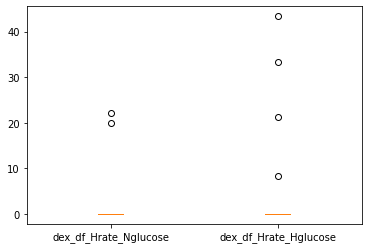

In [291]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
data1 = df_Hrate_Nglucose["dex_win"]
data2 = df_Hrate_Hglucose["dex_win"]
data = [data1, data2]
ax.boxplot(data)
ax.set_xticklabels(["dex_df_Hrate_Nglucose","dex_df_Hrate_Hglucose"])     # 设置x轴刻度标签
plt.show()

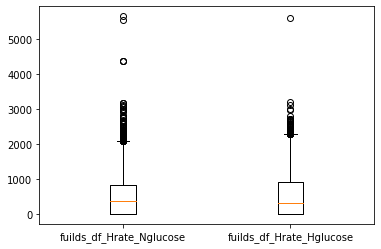

In [292]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
data1 = df_Hrate_Nglucose["colloid_bolus_win"]
data2 = df_Hrate_Hglucose["colloid_bolus_win"]
data = [data1, data2]
ax.boxplot(data)
ax.set_xticklabels(["fuilds_df_Hrate_Nglucose", "fuilds_df_Hrate_Hglucose"]) 
plt.show()

<AxesSubplot:>

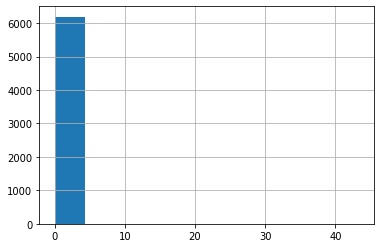

In [297]:
df_Hrate_Hglucose["dex_win"].hist()

<AxesSubplot:>

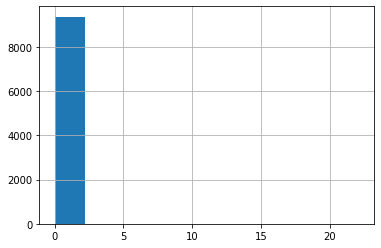

In [296]:
df_Hrate_Nglucose["dex_win"].hist()

In [310]:
tmp_df = pd.merge(df_all_cut, df_rate_9_15, how="inner", on=["stay_id","traj_id","starttime","endtime","rate"])

In [311]:
tmp_df[(tmp_df["type2_diabetes"] ==0) & (tmp_df["type1_diabetes"] ==0)]

,stay_id,traj_id,starttime,endtime,rate,last_rate,glucose_mean,glucose_max,glucose_min,type1_diabetes,type2_diabetes,d_glucose_mean,colloid_bolus_win,dex_win,OS_bt1_0,OS_bt1_1,OS_bt1_2,OS_t0_0,OS_t0_1,OS_t0_2,OS_t1_0,OS_t1_1,OS_t1_2,OS_t2_0,OS_t2_1,OS_t2_2,OS_t3_0,OS_t3_1,OS_t3_2,OS_t4_0,OS_t4_1,OS_t4_2,OS_t5_0,OS_t5_1,OS_t5_2,OS_t6_0,OS_t6_1,OS_t6_2,OS_t7_0,OS_t7_1,OS_t7_2,OS_t8_0,OS_t8_1,OS_t8_2,OS_bv1_0,OS_bv1_1,OS_bv1_2,OS_v0_0,OS_v0_1,OS_v0_2,OS_v1_0,OS_v1_1,OS_v1_2,OS_v2_0,OS_v2_1,OS_v2_2,OS_v3_0,OS_v3_1,OS_v3_2,OS_v4_0,OS_v4_1,OS_v4_2,OS_v5_0,OS_v5_1,OS_v5_2,OS_v6_0,OS_v6_1,OS_v6_2,OS_v7_0,OS_v7_1,OS_v7_2,OS_v8_0,OS_v8_1,OS_v8_2,L_bt1_0,L_bt1_1,L_t0_0,L_t0_1,L_t1_0,L_t1_1,L_t2_0,L_t2_1,L_t3_0,L_t3_1,L_t4_0,L_t4_1,L_t5_0,L_t5_1,L_t6_0,L_t6_1,L_t7_0,L_t7_1,L_t8_0,L_t8_1,L_t9_0,L_t9_1,L_t10_0,L_t10_1,L_t11_0,L_t11_1,L_t12_0,L_t12_1,L_t13_0,L_t13_1,L_t14_0,L_t14_1,L_t15_0,L_t15_1,L_t16_0,L_t16_1,L_t17_0,L_t17_1,L_t18_0,L_t18_1,L_t19_0,L_t19_1,L_t20_0,L_t20_1,L_t21_0,L_t21_1,L_t22_0,L_t22_1,L_t23_0,L_t23_1,L_t24_0,L_t24_1,L_bv1_0,L_bv1_1,L_v0_0,L_v0_1,L_v1_0,L_v1_1,L_v2_0,L_v2_1,L_v3_0,L_v3_1,L_v4_0,L_v4_1,L_v5_0,L_v5_1,L_v6_0,L_v6_1,L_v7_0,L_v7_1,L_v8_0,L_v8_1,L_v9_0,L_v9_1,L_v10_0,L_v10_1,L_v11_0,L_v11_1,L_v12_0,L_v12_1,L_v13_0,L_v13_1,L_v14_0,L_v14_1,L_v15_0,L_v15_1,L_v16_0,L_v16_1,L_v17_0,L_v17_1,L_v18_0,L_v18_1,L_v19_0,L_v19_1,L_v20_0,L_v20_1,L_v21_0,L_v21_1,L_v22_0,L_v22_1,L_v23_0,L_v23_1,L_v24_0,L_v24_1,M_bt1,M_t0,M_t1,M_t2,M_t3,M_t4,M_t5,M_t6,M_t7,M_t8,M_t9,M_t10,M_t11,M_t12,M_bv1,M_v0,M_v1,M_v2,M_v3,M_v4,M_v5,M_v6,M_v7,M_v8,M_v9,M_v10,M_v11,M_v12,idx,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,reward,reward_bin
24,30003749,6,1024.00,1025.00,9.007757,4.001340,300.0,300.0,300.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108,"[[300.0, 268.0, 289.0]]",0.000000,[],NaN,NaN,NaN,F,0.000000,8.0
25,30003749,6,1202.00,1262.00,9.497314,9.497314,131.5,162.0,101.0,0.0,0.0,-37.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112,[],NaN,"[[169.0, 162.0, 101.0, 105.0]]",4.333333,TD,NaN,S,4.333333,8.0
26,30003749,6,1262.00,1322.00,9.497314,9.497314,105.0,105.0,105.0,0.0,0.0,-26.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.